Enter stock ticker (e.g., AAPL, MSFT):  NTPC.NS


Fetching data for NTPC.NS from 2020-06-26 to 2025-06-26...


[*********************100%***********************]  1 of 1 completed


Data fetched successfully. Rows: 1239

--- Performing Descriptive Analysis ---

--- Performing Diagnostic Analysis ---

--- Performing Predictive Analysis ---
Finding optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6510.948, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6513.575, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6513.075, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6513.082, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6510.025, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.626 seconds
Selected ARIMA(0, 1, 0) model

Performing walk-forward validation...

Training final model...


Running Monte Carlo Simulations: 100%|██████████| 5000/5000 [00:09<00:00, 523.97it/s]


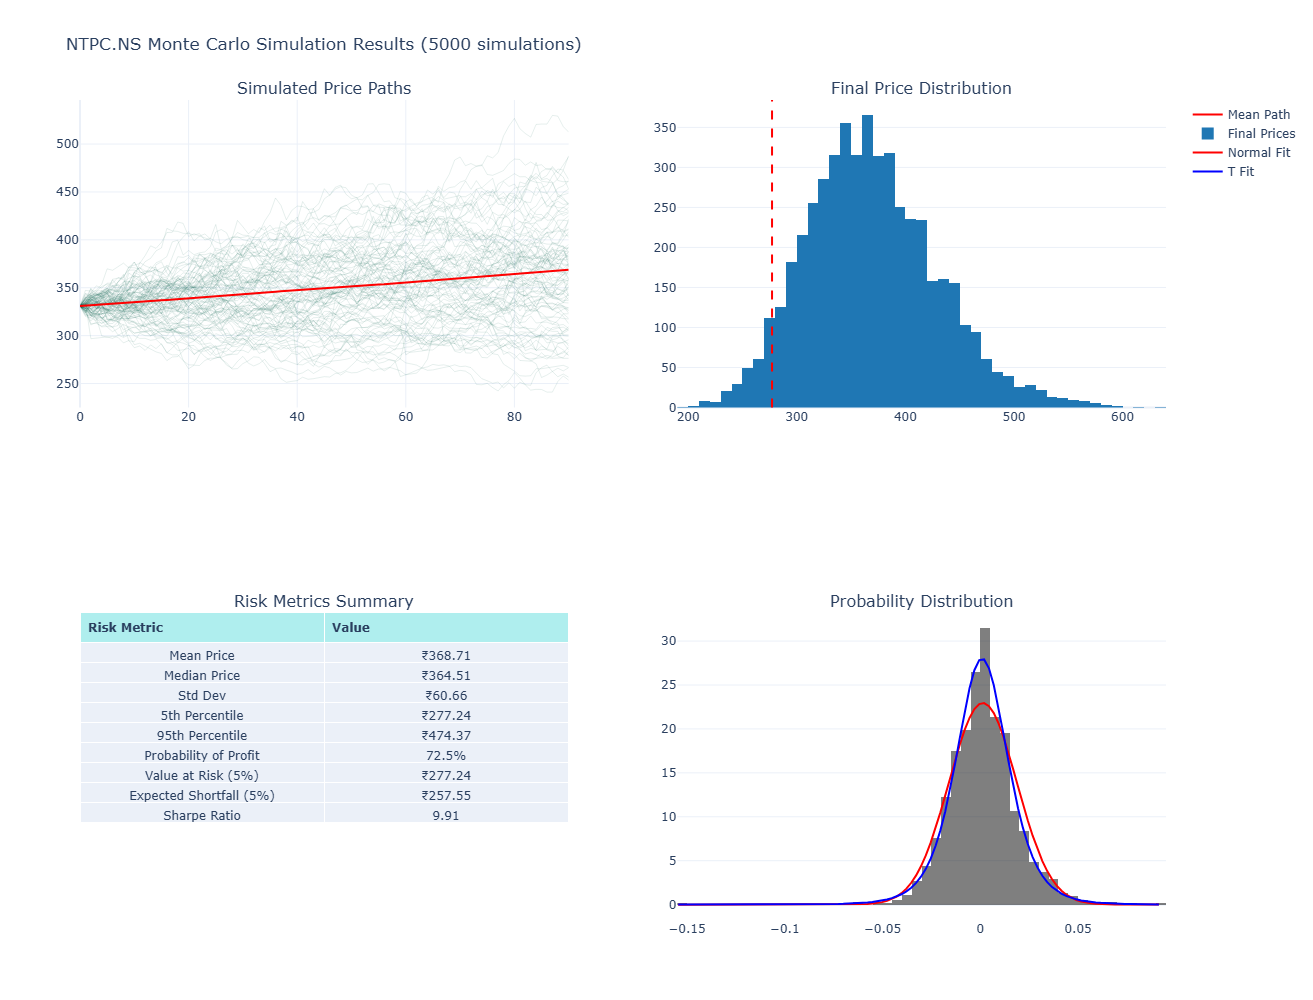


--- Performing Prescriptive Analysis ---

--- Generating Plots for NTPC.NS ---


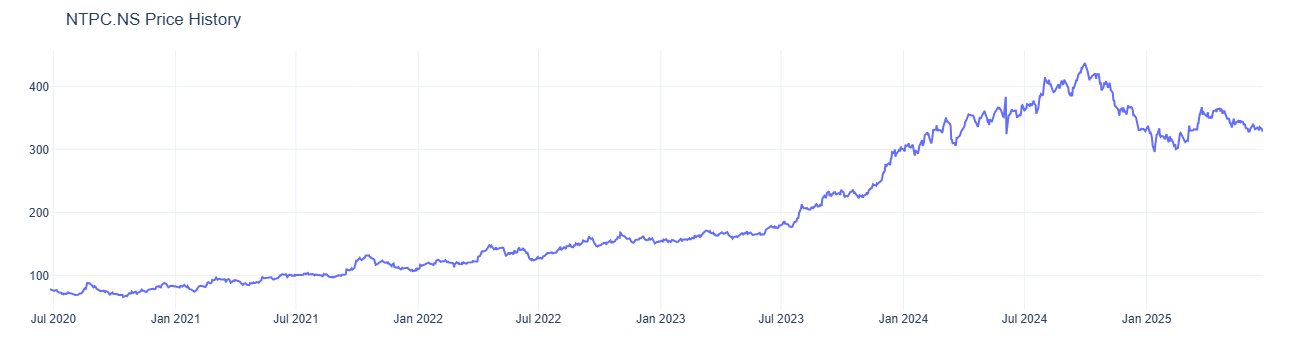

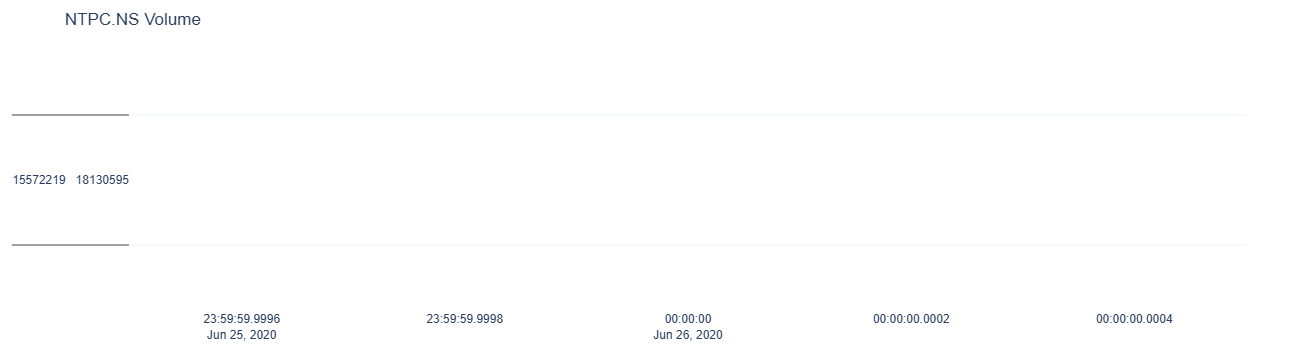

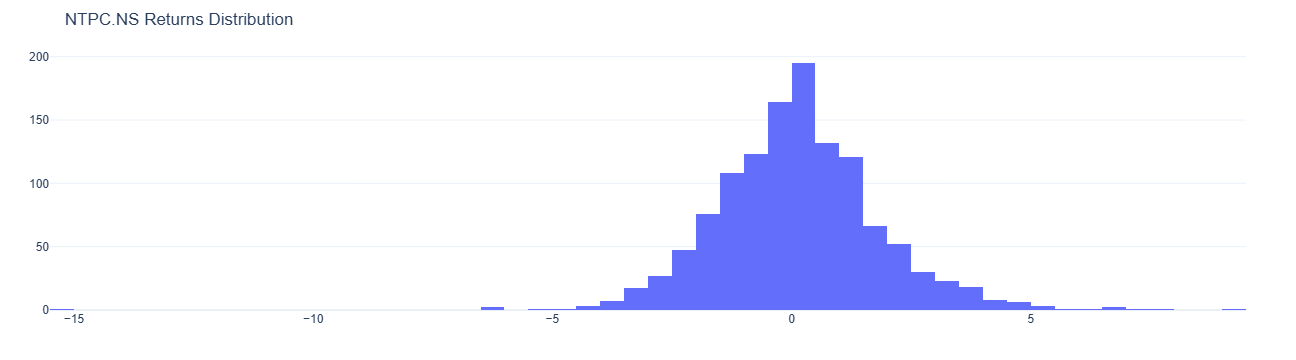

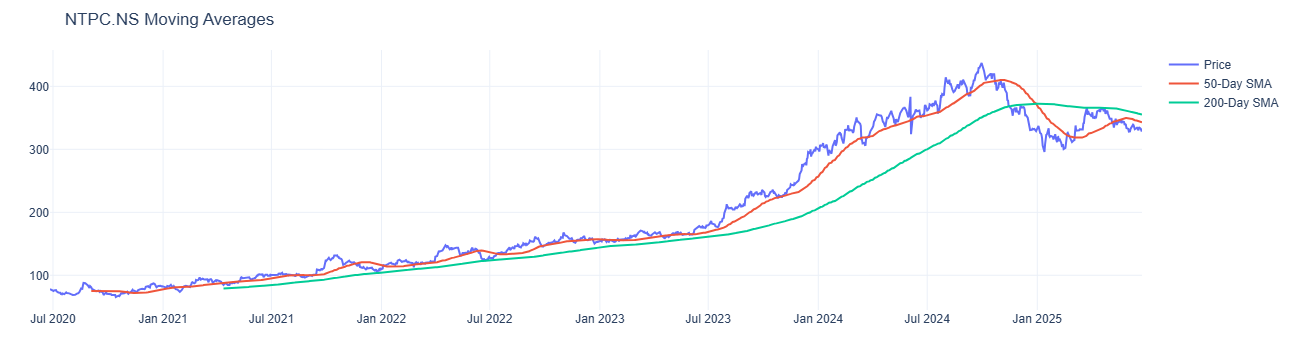

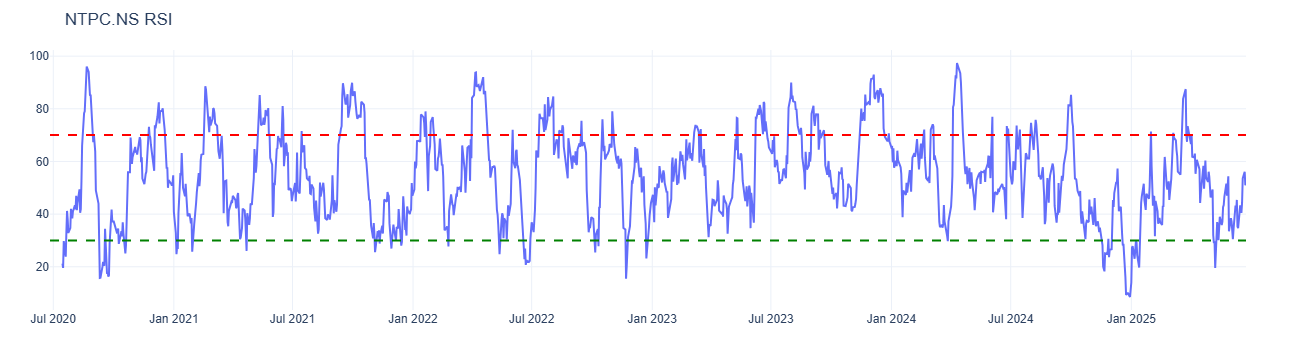

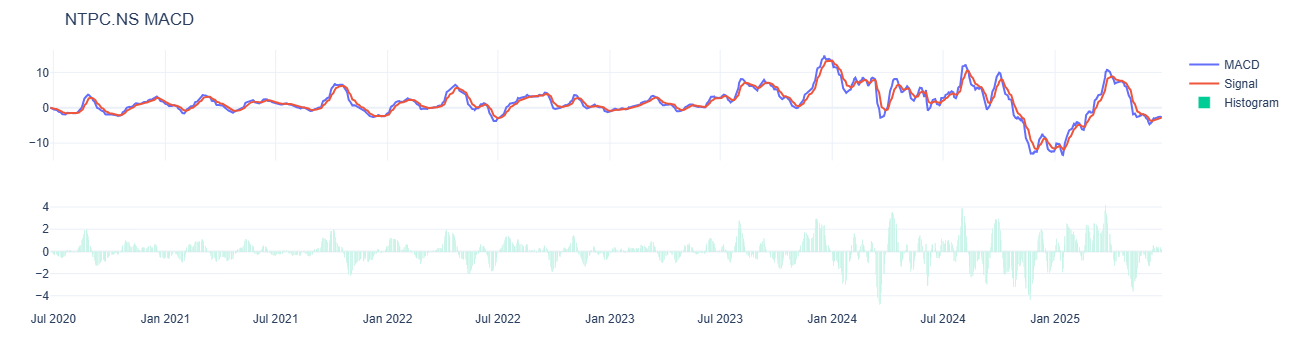

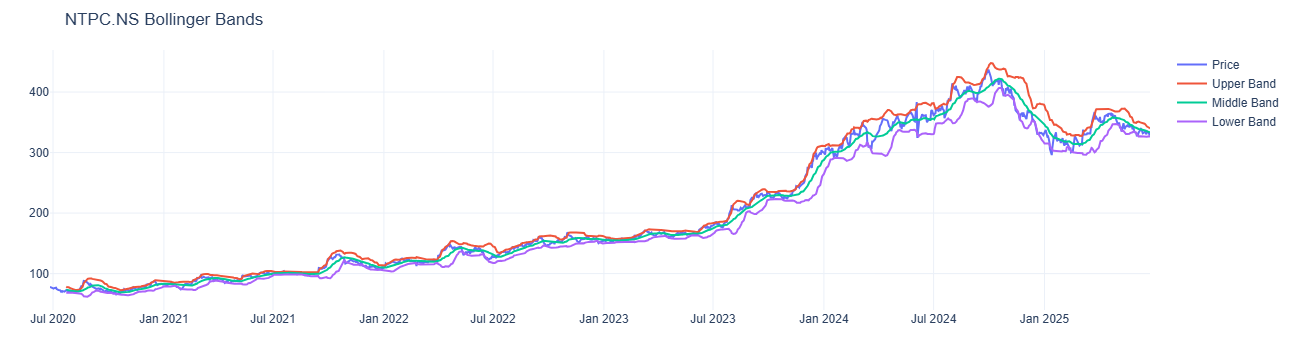

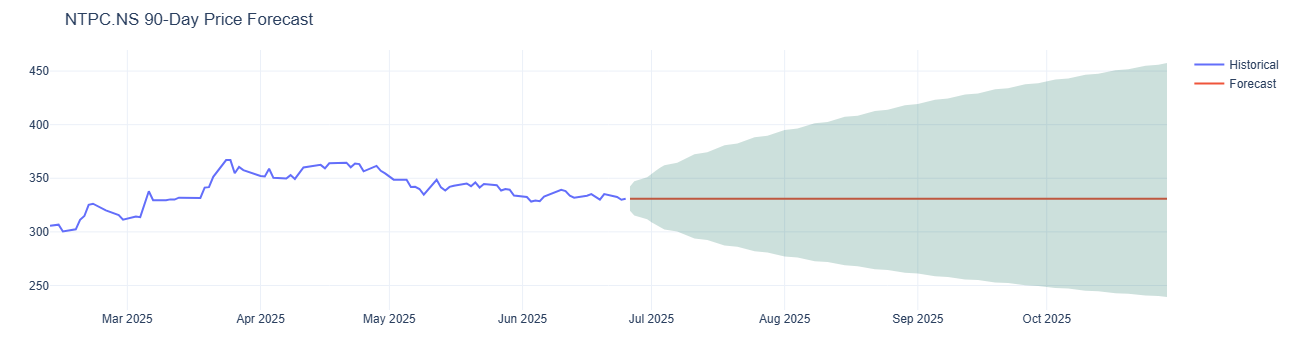

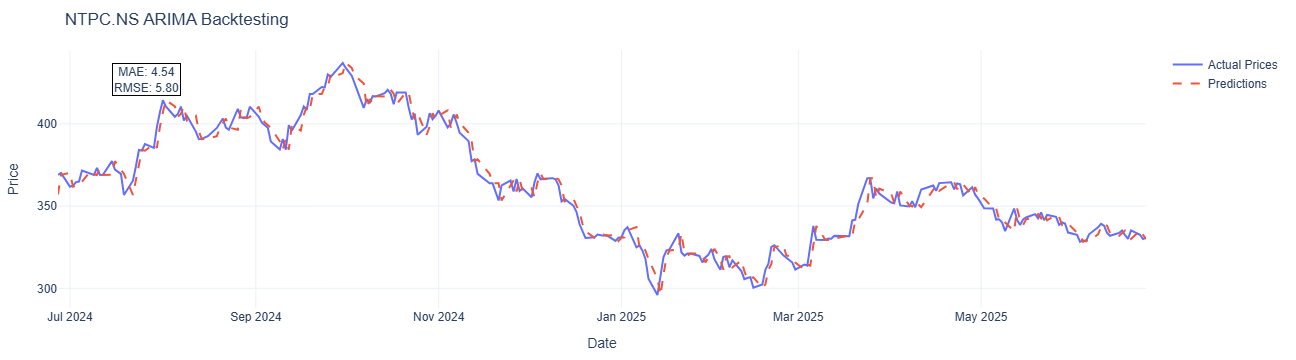

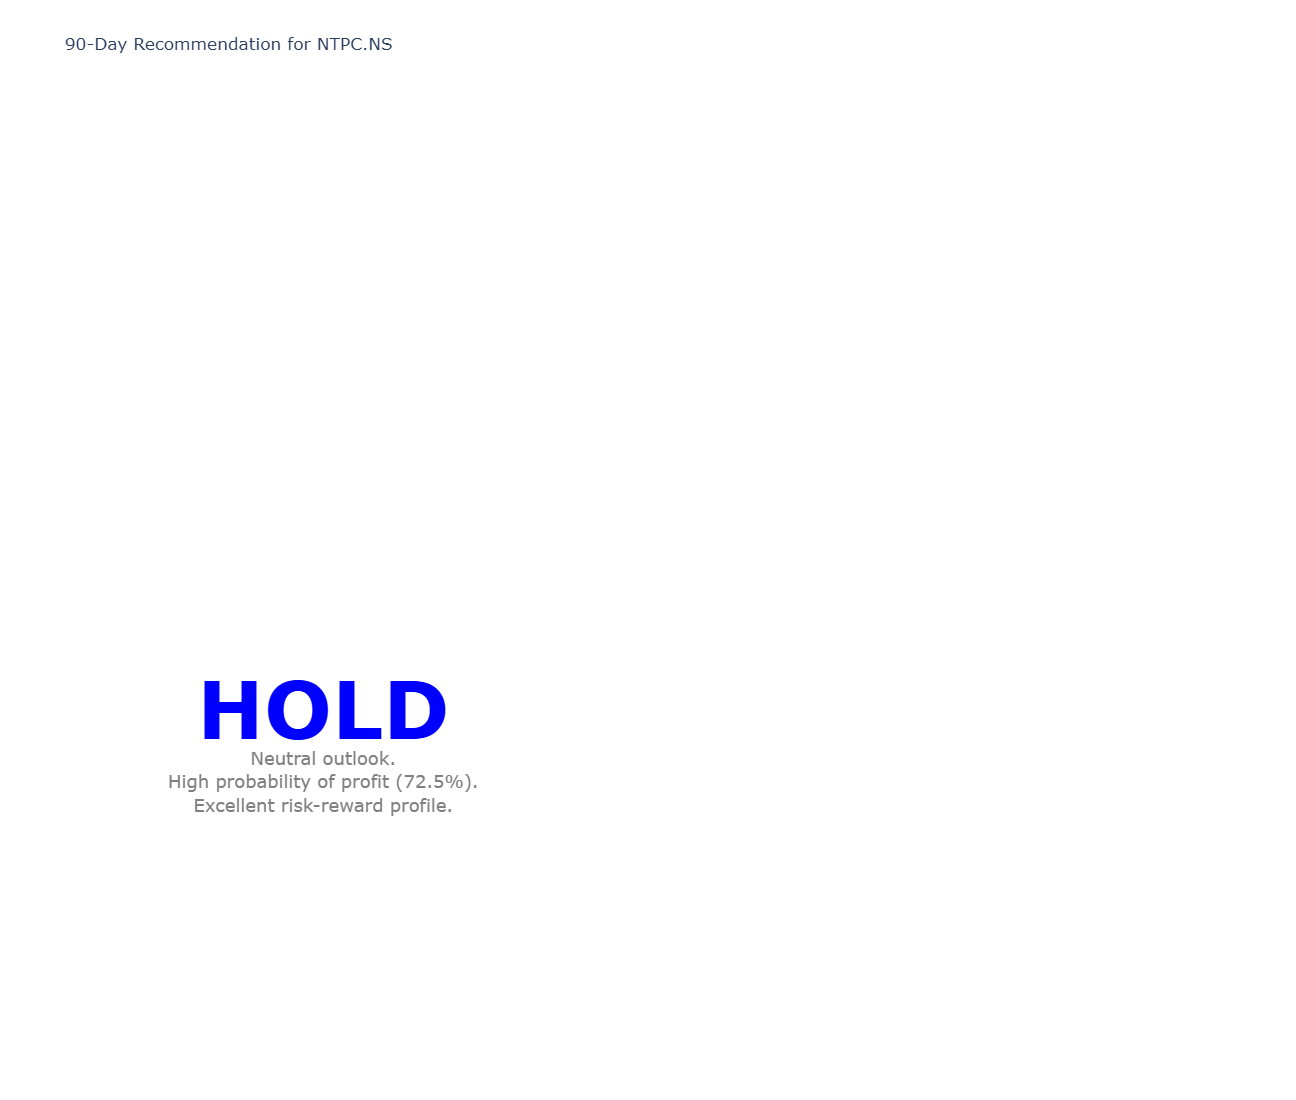

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.arima.model import ARIMA
import warnings
import traceback
from pmdarima import auto_arima
from scipy.stats import norm, t, skewnorm, kurtosis
from scipy.stats import skew
import random
from tqdm import tqdm

warnings.filterwarnings("ignore")

# --- 1. Data Acquisition ---
def fetch_stock_data(ticker_symbol, start_date, end_date):
    print(f"Fetching data for {ticker_symbol} from {start_date} to {end_date}...")
    try:
        data = yf.download(ticker_symbol, start=start_date, end=end_date)
        if data.empty:
            print(f"Error: No data found for {ticker_symbol}.")
            return None

        if 'Adj Close' not in data.columns:
            print(f"Warning: Using 'Close' price instead of 'Adj Close'.")
            if 'Close' in data.columns:
                data['Adj Close'] = data['Close']
            else:
                print(f"Error: No price column found.")
                return None

        print(f"Data fetched successfully. Rows: {len(data)}")
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        traceback.print_exc()
        return None

# --- 2. Descriptive Analysis ---
def descriptive_analysis(data):
    print("\n--- Performing Descriptive Analysis ---")
    data['Daily_Return'] = data['Adj Close'].pct_change() * 100

    price_stats = {
        'Mean Price': data['Adj Close'].mean(),
        'Median Price': data['Adj Close'].median(),
        'Std Dev Price': data['Adj Close'].std(),
        'Min Price': data['Adj Close'].min(),
        'Max Price': data['Adj Close'].max()
    }

    returns_stats = {
        'Mean Daily Return (%)': data['Daily_Return'].mean(),
        'Median Daily Return (%)': data['Daily_Return'].median(),
        'Std Dev Daily Return (%)': data['Daily_Return'].std(),
        'Min Daily Return (%)': data['Daily_Return'].min(),
        'Max Daily Return (%)': data['Daily_Return'].max(),
        'Skewness': skew(data['Daily_Return'].dropna()),
        'Kurtosis': kurtosis(data['Daily_Return'].dropna())
    }

    return price_stats, returns_stats, data['Daily_Return'].dropna()

# --- 3. Diagnostic Analysis ---
def diagnostic_analysis(data):
    print("\n--- Performing Diagnostic Analysis ---")

    # Moving Averages
    data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Adj Close'].rolling(window=200).mean()

    # RSI
    delta = data['Adj Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan)
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = data['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Adj Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']

    # Bollinger Bands
    data['Bollinger_Middle'] = data['Adj Close'].rolling(window=20).mean()
    std_dev_20 = data['Adj Close'].rolling(window=20).std()
    data['Bollinger_Upper'] = data['Bollinger_Middle'] + (std_dev_20 * 2)
    data['Bollinger_Lower'] = data['Bollinger_Middle'] - (std_dev_20 * 2)

    return data

# --- 4. Predictive Analysis ---
def predictive_analysis(data, forecast_horizon=90):  # Changed to 90 days
    print(f"\n--- Performing Predictive Analysis ---")
    
    if data['Adj Close'].empty or len(data) < 100:
        print("Error: Not enough data points.")
        return pd.Series(), pd.DataFrame(), {}

    try:
        # Prepare data
        arima_data = np.log(data['Adj Close'].dropna())
        
        # Auto ARIMA
        print("Finding optimal ARIMA parameters...")
        model = auto_arima(
            arima_data,
            start_p=1, start_q=1,
            max_p=5, max_q=5,
            d=None,
            seasonal=False,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        order = model.order
        print(f"Selected ARIMA{order} model")

        # Walk-forward validation
        print("\nPerforming walk-forward validation...")
        train_size = int(len(arima_data) * 0.8)
        train, test = arima_data[:train_size], arima_data[train_size:]
        
        history = [x for x in train]
        predictions = []
        confidence_intervals = []
        test_dates = test.index
        
        for t in range(len(test)):
            current_model = ARIMA(history, order=order)
            current_model_fit = current_model.fit()
            forecast_result = current_model_fit.get_forecast(steps=1)
            
            if hasattr(forecast_result.predicted_mean, 'iloc'):
                yhat = forecast_result.predicted_mean.iloc[0]
                ci = forecast_result.conf_int().iloc[0].values
            else:
                yhat = forecast_result.predicted_mean[0]
                ci = forecast_result.conf_int()[0]
                
            predictions.append(yhat)
            confidence_intervals.append(ci)
            history.append(test.iloc[t])
        
        # Calculate metrics
        test_values = np.exp(test.values)
        predictions = np.exp(np.array(predictions))
        confidence_intervals = np.exp(np.array(confidence_intervals))
        
        mae = np.mean(np.abs(predictions - test_values))
        mse = np.mean((predictions - test_values)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((predictions - test_values) / test_values)) * 100
        
        backtest_metrics = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'Test_Start_Date': test.index[0],
            'Test_End_Date': test.index[-1],
            'Predictions': predictions,
            'Test_Values': test_values,
            'Test_Dates': test_dates
        }

        # Final model
        print("\nTraining final model...")
        final_model = ARIMA(arima_data, order=order)
        final_model_fit = final_model.fit()
        forecast_results = final_model_fit.get_forecast(steps=forecast_horizon)
        
        if hasattr(forecast_results.predicted_mean, 'iloc'):
            forecast_prices = np.exp(forecast_results.predicted_mean)
            confidence_interval = np.exp(forecast_results.conf_int())
        else:
            forecast_prices = pd.Series(np.exp(forecast_results.predicted_mean))
            confidence_interval = pd.DataFrame(np.exp(forecast_results.conf_int()))
        
        last_date = data.index[-1]
        forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                     periods=forecast_horizon, freq='B')
        forecast_prices.index = forecast_index
        confidence_interval.index = forecast_index

        return forecast_prices, confidence_interval, backtest_metrics
        
    except Exception as e:
        print(f"Error during ARIMA forecasting: {e}")
        traceback.print_exc()
        return pd.Series(), pd.DataFrame(), {}

# --- Monte Carlo Simulation Class ---
class MonteCarloSimulator:
    def __init__(self, returns_series, num_simulations=10000, forecast_days=90):  # Changed to 90 days
        self.returns = returns_series
        self.num_simulations = num_simulations
        self.forecast_days = forecast_days
        self.current_price = None
        self.simulated_paths = None
        self.risk_metrics = None
        
    def fit_distributions(self):
        self.normal_params = norm.fit(self.returns)
        self.t_params = t.fit(self.returns)
        
        try:
            self.skewnorm_params = skewnorm.fit(self.returns)
        except:
            self.skewnorm_params = None
            
        self.empirical_dist = self.returns.values
    
    def generate_simulated_paths(self, current_price):
        self.current_price = current_price
        self.fit_distributions()
        
        self.simulated_paths = np.zeros((self.num_simulations, self.forecast_days + 1))
        self.simulated_paths[:, 0] = current_price
        
        for i in tqdm(range(self.num_simulations), desc="Running Monte Carlo Simulations"):
            model_choice = random.choice(['normal', 't', 'empirical', 'skewnorm'])
            
            for day in range(1, self.forecast_days + 1):
                if model_choice == 'normal':
                    daily_return = norm.rvs(*self.normal_params)
                elif model_choice == 't':
                    daily_return = t.rvs(*self.t_params)
                elif model_choice == 'skewnorm' and self.skewnorm_params is not None:
                    daily_return = skewnorm.rvs(*self.skewnorm_params)
                else:
                    daily_return = np.random.choice(self.empirical_dist)
                
                self.simulated_paths[i, day] = self.simulated_paths[i, day-1] * (1 + daily_return)
    
    def calculate_risk_metrics(self):
        if self.simulated_paths is None:
            raise ValueError("Run simulations first using generate_simulated_paths()")
            
        final_prices = self.simulated_paths[:, -1]
        returns = (final_prices - self.current_price) / self.current_price
        
        self.risk_metrics = {
            'mean_price': np.mean(final_prices),
            'median_price': np.median(final_prices),
            'std_dev': np.std(final_prices),
            'min_price': np.min(final_prices),
            'max_price': np.max(final_prices),
            '5th_percentile': np.percentile(final_prices, 5),
            '95th_percentile': np.percentile(final_prices, 95),
            'probability_profit': np.mean(returns > 0) * 100,
            'expected_shortfall_5%': np.mean(final_prices[final_prices <= np.percentile(final_prices, 5)]),
            'value_at_risk_5%': np.percentile(final_prices, 5),
            'sharpe_ratio': np.mean(returns) / np.std(returns) * np.sqrt(252),
            'kurtosis': kurtosis(final_prices),
            'skewness': skew(final_prices)
        }
        
        return self.risk_metrics
        
    def plot_simulation_results(self, ticker_symbol):
        if self.simulated_paths is None or self.risk_metrics is None:
            raise ValueError("Run simulations and calculate metrics first")
            
        # MODIFICATION HERE: Define subplot types using 'specs'
        fig = make_subplots(
            rows=2, cols=2, 
            subplot_titles=(
                "Simulated Price Paths", 
                "Final Price Distribution",
                "Risk Metrics Summary",
                "Probability Distribution"
            ),
            # Define specs for each subplot
            specs=[
                [{'type': 'xy'}, {'type': 'xy'}],  # Row 1: XY plots
                [{'type': 'table'}, {'type': 'xy'}]  # Row 2: Table, then XY plot
            ]
        )
        
        # Plot 1: Sample of simulated paths
        for i in range(min(100, self.num_simulations)):
            fig.add_trace(
                go.Scatter(
                    x=list(range(self.forecast_days + 1)),
                    y=self.simulated_paths[i],
                    mode='lines',
                    line=dict(width=1, color='rgba(0,100,80,0.1)'),
                    showlegend=False
                ),
                row=1, col=1
            )
        
        # Add mean path
        mean_path = np.mean(self.simulated_paths, axis=0)
        fig.add_trace(
            go.Scatter(
                x=list(range(self.forecast_days + 1)),
                y=mean_path,
                mode='lines',
                line=dict(width=2, color='red'),
                name='Mean Path'
            ),
            row=1, col=1
        )
        
        # Plot 2: Histogram of final prices
        fig.add_trace(
            go.Histogram(
                x=self.simulated_paths[:, -1],
                nbinsx=50,
                name='Final Prices',
                marker_color='#1f77b4'
            ),
            row=1, col=2
        )
        
        # Add VaR line
        fig.add_vline(
            x=self.risk_metrics['value_at_risk_5%'],
            line=dict(color='red', dash='dash'),
            row=1, col=2
        )
        
        # Plot 3: Risk metrics table
        # The metrics_text variable is no longer directly used for the table content,
        # but it's fine to keep if you use it elsewhere or for debugging.
        metrics_text = [
            f"<b>Mean Price:</b> ₹{self.risk_metrics['mean_price']:.2f}",
            f"<b>Median Price:</b> ₹{self.risk_metrics['median_price']:.2f}",
            f"<b>Std Dev:</b> ₹{self.risk_metrics['std_dev']:.2f}",
            f"<b>5th Percentile:</b> ₹{self.risk_metrics['5th_percentile']:.2f}",
            f"<b>95th Percentile:</b> ₹{self.risk_metrics['95th_percentile']:.2f}",
            f"<b>Probability of Profit:</b> {self.risk_metrics['probability_profit']:.1f}%",
            f"<b>Value at Risk (5%):</b> ₹{self.risk_metrics['value_at_risk_5%']:.2f}",
            f"<b>Expected Shortfall (5%):</b> ₹{self.risk_metrics['expected_shortfall_5%']:.2f}",
            f"<b>Sharpe Ratio:</b> {self.risk_metrics['sharpe_ratio']:.2f}"
        ]
        
        fig.add_trace(
            go.Table(
                header=dict(values=['<b>Risk Metric</b>', '<b>Value</b>'],
                            fill_color='paleturquoise',
                            align='left'),
                cells=dict(values=[
                    ["Mean Price", "Median Price", "Std Dev",
                     "5th Percentile", "95th Percentile",
                     "Probability of Profit",
                     "Value at Risk (5%)",
                     "Expected Shortfall (5%)",
                     "Sharpe Ratio"],
                    [f"₹{self.risk_metrics['mean_price']:.2f}",
                     f"₹{self.risk_metrics['median_price']:.2f}",
                     f"₹{self.risk_metrics['std_dev']:.2f}",
                     f"₹{self.risk_metrics['5th_percentile']:.2f}",
                     f"₹{self.risk_metrics['95th_percentile']:.2f}",
                     f"{self.risk_metrics['probability_profit']:.1f}%",
                     f"₹{self.risk_metrics['value_at_risk_5%']:.2f}",
                     f"₹{self.risk_metrics['expected_shortfall_5%']:.2f}",
                     f"{self.risk_metrics['sharpe_ratio']:.2f}"
                    ]
                ]),
                columnwidth=[1, 1]
            ),
            row=2, col=1
        )
        
        # Plot 4: Probability distribution comparison
        x = np.linspace(min(self.returns), max(self.returns), 100)
        
        # Normal distribution
        fig.add_trace(
            go.Scatter(
                x=x,
                y=norm.pdf(x, *self.normal_params),
                mode='lines',
                name='Normal Fit',
                line=dict(color='red')
            ),
            row=2, col=2
        )
        
        # T distribution
        fig.add_trace(
            go.Scatter(
                x=x,
                y=t.pdf(x, *self.t_params),
                mode='lines',
                name='T Fit',
                line=dict(color='blue')
            ),
            row=2, col=2
        )
        
        # Empirical distribution
        fig.add_trace(
            go.Histogram(
                x=self.returns,
                histnorm='probability density',
                name='Empirical',
                marker_color='rgba(0,0,0,0.5)',
                showlegend=False
            ),
            row=2, col=2
        )
        
        fig.update_layout(
            title_text=f"{ticker_symbol} Monte Carlo Simulation Results ({self.num_simulations} simulations)",
            height=1000,
            showlegend=True,
            template="plotly_white"
        )
        
        fig.show()

# --- 5. Prescriptive Analysis ---
def prescriptive_analysis(data, forecast_prices, risk_metrics=None):
    print("\n--- Performing Prescriptive Analysis ---")

    signal = "HOLD"
    reason = "Neutral outlook."

    if data.empty or forecast_prices.empty or len(data) < 200:
        return signal, reason

    latest_close = data['Adj Close'].iloc[-1]
    
    # Get indicator values with safety checks
    indicators = {}
    for col in ['SMA_50', 'SMA_200', 'RSI', 'MACD', 'Signal_Line']:
        indicators[col] = data[col].iloc[-1] if col in data.columns and not pd.isna(data[col].iloc[-1]) else None

    # Predictive trend
    predictive_trend = "neutral"
    if not forecast_prices.empty:
        if forecast_prices.iloc[-1] > forecast_prices.iloc[0] * 1.05:  # More sensitive threshold for 90 days
            predictive_trend = "bullish"
        elif forecast_prices.iloc[-1] < forecast_prices.iloc[0] * 0.95:  # More sensitive threshold for 90 days
            predictive_trend = "bearish"

    # Signal logic
    if all(v is not None for v in indicators.values()):
        if (latest_close > indicators['SMA_50'] and 
            indicators['SMA_50'] > indicators['SMA_200'] and
            indicators['RSI'] < 70 and
            indicators['MACD'] > indicators['Signal_Line'] and
            predictive_trend == "bullish"):
            signal = "STRONG BUY" if (risk_metrics and risk_metrics['probability_profit'] > 65) else "BUY"
            reason = "Strong bullish confluence"
        elif (latest_close < indicators['SMA_50'] and 
              indicators['SMA_50'] < indicators['SMA_200'] and
              indicators['RSI'] > 30 and
              indicators['MACD'] < indicators['Signal_Line'] and
              predictive_trend == "bearish"):
            signal = "STRONG SELL" if (risk_metrics and risk_metrics['probability_profit'] < 35) else "SELL"
            reason = "Strong bearish confluence"
        elif indicators['RSI'] > 70:
            signal = "SELL (Overbought)"
            reason = "Overbought based on RSI"
        elif indicators['RSI'] < 30:
            signal = "BUY (Oversold)"
            reason = "Oversold based on RSI"

    # Enhance with simulation results if available
    if risk_metrics is not None:
        if risk_metrics['probability_profit'] > 65:
            reason += f" High probability of profit ({risk_metrics['probability_profit']:.1f}%)."
        elif risk_metrics['probability_profit'] < 35:
            reason += f" Low probability of profit ({risk_metrics['probability_profit']:.1f}%)."
        
        if risk_metrics['sharpe_ratio'] > 1.5:
            reason += " Excellent risk-reward profile."
        elif risk_metrics['sharpe_ratio'] < 0:
            reason += " Poor risk-reward profile."

    return signal, reason

# --- 6. Enhanced Plotting Function ---
def generate_plotly_plots(data, descriptive_stats, returns_data, forecast_prices, confidence_interval, ticker_symbol, backtest_metrics=None):
    print(f"\n--- Generating Plots for {ticker_symbol} ---")
    
    common_layout = {
        'template': "plotly_white",
        'font': dict(family="Inter, sans-serif"),
        'hovermode': "x unified",
        'margin': dict(l=50, r=50, t=50, b=50),
    }

    # Plot 1: Historical Price
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], mode='lines', name='Price'))
    fig1.update_layout(title=f'{ticker_symbol} Price History', **common_layout)
    fig1.show()

    # Plot 2: Volume
    fig2 = go.Figure()
    fig2.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Volume'))
    fig2.update_layout(title=f'{ticker_symbol} Volume', **common_layout)
    fig2.show()

    # Plot 3: Returns Distribution
    fig3 = go.Figure()
    fig3.add_trace(go.Histogram(x=returns_data, nbinsx=50, name='Returns'))
    fig3.update_layout(title=f'{ticker_symbol} Returns Distribution', **common_layout)
    fig3.show()

    # Plot 4: Moving Averages
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], name='Price'))
    fig4.add_trace(go.Scatter(x=data.index, y=data['SMA_50'], name='50-Day SMA'))
    fig4.add_trace(go.Scatter(x=data.index, y=data['SMA_200'], name='200-Day SMA'))
    fig4.update_layout(title=f'{ticker_symbol} Moving Averages', **common_layout)
    fig4.show()

    # Plot 5: RSI
    fig5 = go.Figure()
    fig5.add_trace(go.Scatter(x=data.index, y=data['RSI'], name='RSI'))
    fig5.add_hline(y=70, line_dash="dash", line_color="red")
    fig5.add_hline(y=30, line_dash="dash", line_color="green")
    fig5.update_layout(title=f'{ticker_symbol} RSI', **common_layout)
    fig5.show()

    # Plot 6: MACD
    fig6 = make_subplots(rows=2, cols=1, shared_xaxes=True)
    fig6.add_trace(go.Scatter(x=data.index, y=data['MACD'], name='MACD'), row=1, col=1)
    fig6.add_trace(go.Scatter(x=data.index, y=data['Signal_Line'], name='Signal'), row=1, col=1)
    fig6.add_trace(go.Bar(x=data.index, y=data['MACD_Histogram'], name='Histogram'), row=2, col=1)
    fig6.update_layout(title=f'{ticker_symbol} MACD', **common_layout)
    fig6.show()

    # Plot 7: Bollinger Bands
    fig7 = go.Figure()
    fig7.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], name='Price'))
    fig7.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Upper'], name='Upper Band'))
    fig7.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Middle'], name='Middle Band'))
    fig7.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Lower'], name='Lower Band'))
    fig7.update_layout(title=f'{ticker_symbol} Bollinger Bands', **common_layout)
    fig7.show()

    # Plot 8: Forecast
    if not forecast_prices.empty:
        fig8 = go.Figure()
        fig8.add_trace(go.Scatter(x=data.index[-90:], y=data['Adj Close'].iloc[-90:], name='Historical'))
        fig8.add_trace(go.Scatter(x=forecast_prices.index, y=forecast_prices, name='Forecast'))
        fig8.add_trace(go.Scatter(
            x=confidence_interval.index.tolist() + confidence_interval.index.tolist()[::-1],
            y=confidence_interval.iloc[:, 1].tolist() + confidence_interval.iloc[:, 0].tolist()[::-1],
            fill='toself', fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            showlegend=False
        ))
        fig8.update_layout(title=f'{ticker_symbol} 90-Day Price Forecast', **common_layout)
        fig8.show()

    # Plot 9: Backtesting (if available)
    if backtest_metrics and 'Test_Dates' in backtest_metrics:
        fig9 = go.Figure()
        fig9.add_trace(go.Scatter(
            x=backtest_metrics['Test_Dates'],
            y=backtest_metrics['Test_Values'],
            name='Actual Prices'
        ))
        fig9.add_trace(go.Scatter(
            x=backtest_metrics['Test_Dates'],
            y=backtest_metrics['Predictions'],
            name='Predictions',
            line=dict(dash='dash')
        ))
        fig9.update_layout(
            title=f'{ticker_symbol} ARIMA Backtesting',
            xaxis_title='Date',
            yaxis_title='Price',
            annotations=[
                dict(
                    x=0.05,
                    y=0.95,
                    xref='paper',
                    yref='paper',
                    text=f"MAE: {backtest_metrics['MAE']:.2f}<br>RMSE: {backtest_metrics['RMSE']:.2f}",
                    showarrow=False,
                    bgcolor='white',
                    bordercolor='black',
                    borderwidth=1
                )
            ],
            **common_layout
        )
        fig9.show()

# --- 7. Final Verdict Display ---
def display_final_verdict_plot(signal, reason, ticker_symbol):
    if 'BUY' in signal:
        color = 'green'
    elif 'SELL' in signal:
        color = 'red'
    else:
        color = 'blue'
    
    fig = go.Figure()
    fig.add_annotation(
        text=f"<b>{signal}</b>",
        x=0.5, y=0.7,
        showarrow=False,
        font=dict(size=80, color=color)
    )
    fig.add_annotation(
        text=reason.replace('. ', '.<br>'),
        x=0.5, y=0.3,
        showarrow=False,
        font=dict(size=18, color='gray')
    )
    fig.update_layout(
        title=f"90-Day Recommendation for {ticker_symbol}",
        xaxis=dict(showgrid=False, showticklabels=False),
        yaxis=dict(showgrid=False, showticklabels=False),
        plot_bgcolor='white',
        height=1100,
        width=800
    )
    fig.show()

# --- Main Function ---
def analyze_stock(ticker_symbol):
    end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
    start_date = (pd.to_datetime('today') - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

    # 1. Data Acquisition
    data = fetch_stock_data(ticker_symbol, start_date, end_date)
    if data is None:
        return

    # 2. Descriptive Analysis
    if len(data) < 2:
        price_stats, returns_stats, daily_returns = {}, {}, pd.Series()
    else:
        price_stats, returns_stats, daily_returns = descriptive_analysis(data.copy())

    # 3. Diagnostic Analysis
    data = diagnostic_analysis(data)

    # 4. Predictive Analysis (90-day forecast)
    if len(data) < 100:
        forecast_prices, confidence_interval, backtest_metrics = pd.Series(), pd.DataFrame(), {}
    else:
        forecast_prices, confidence_interval, backtest_metrics = predictive_analysis(data.copy(), forecast_horizon=90)

    # 5. Monte Carlo Simulation (90-day forecast)
    risk_metrics = None
    if len(daily_returns) > 50:
        returns_decimal = daily_returns / 100
        
        simulator = MonteCarloSimulator(
            returns_series=returns_decimal,
            num_simulations=5000,
            forecast_days=90
        )
        
        current_price = data['Adj Close'].iloc[-1]
        simulator.generate_simulated_paths(current_price)
        risk_metrics = simulator.calculate_risk_metrics()
        simulator.plot_simulation_results(ticker_symbol)
    else:
        print("\nInsufficient data for Monte Carlo simulations")

    # 6. Prescriptive Analysis
    signal, reason = prescriptive_analysis(data, forecast_prices, risk_metrics)

    # 7. Generate Plots
    generate_plotly_plots(
        data, price_stats, daily_returns, 
        forecast_prices, confidence_interval, 
        ticker_symbol, backtest_metrics
    )

    # 8. Display Verdict
    display_final_verdict_plot(signal, reason, ticker_symbol)

# --- Run Analysis ---
if __name__ == "__main__":
    stock_symbol = input("Enter stock ticker (e.g., AAPL, MSFT): ").strip()
    analyze_stock(stock_symbol)



[*********************100%***********************]  1 of 1 completed


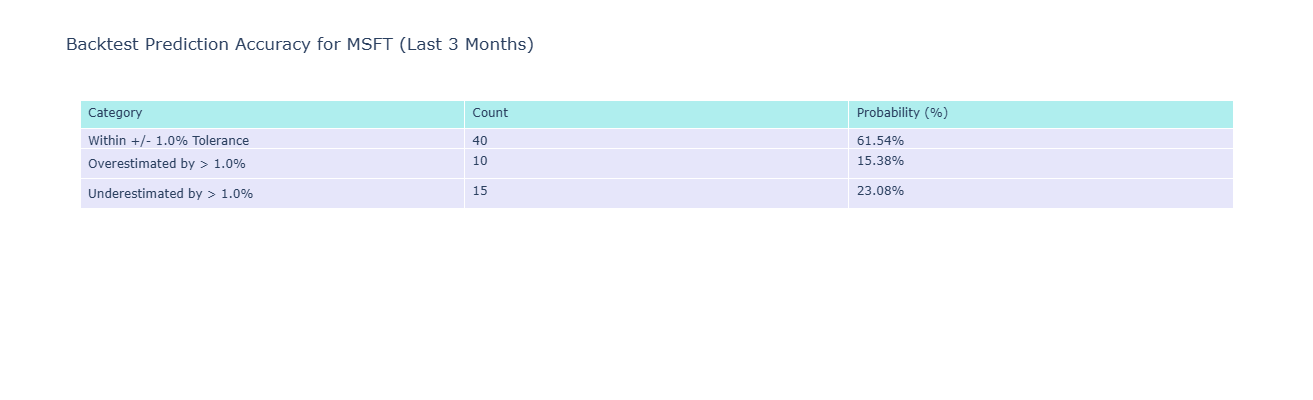

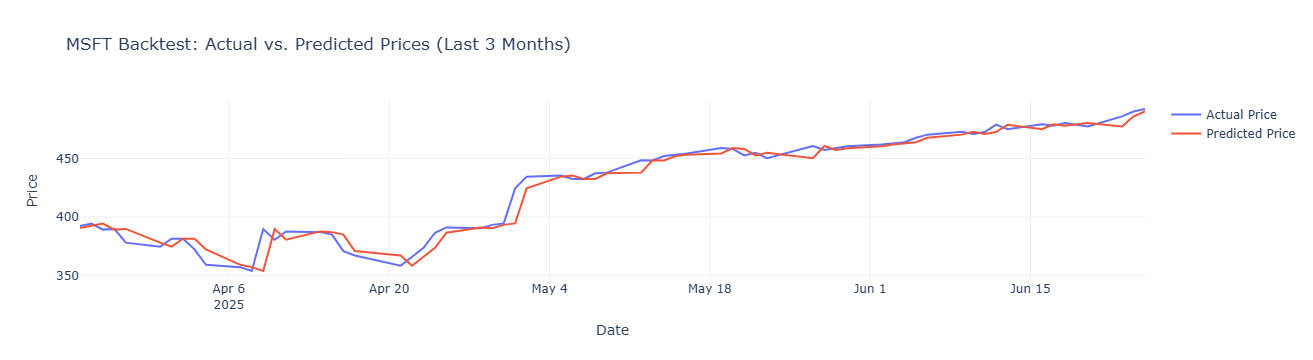

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import warnings
import traceback
from pmdarima import auto_arima
from scipy.stats import norm, t, skewnorm, kurtosis
from scipy.stats import skew
import random
from tqdm import tqdm

warnings.filterwarnings("ignore")

def fetch_stock_data(ticker_symbol, start_date, end_date):
    try:
        data = yf.download(ticker_symbol, start=start_date, end=end_date)
        if data.empty:
            return None
        if 'Adj Close' not in data.columns:
            if 'Close' in data.columns:
                data['Adj Close'] = data['Close']
            else:
                return None
        return data
    except Exception as e:
        return None

def predictive_analysis(data, forecast_horizon=90):
    if data['Adj Close'].empty or len(data) < 100:
        return pd.Series(), pd.DataFrame(), {}
    try:
        arima_data = np.log(data['Adj Close'].dropna())
        model = auto_arima(
            arima_data,
            start_p=1, start_q=1,
            max_p=5, max_q=5,
            d=None,
            seasonal=False,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        order = model.order
        
        train_size = int(len(arima_data) * 0.8)
        train, test = arima_data[:train_size], arima_data[train_size:]
        
        history = [x for x in train]
        predictions = []
        test_dates = test.index
        
        for t_idx in range(len(test)):
            current_model = ARIMA(history, order=order)
            current_model_fit = current_model.fit()
            forecast_result = current_model_fit.get_forecast(steps=1)
            
            if hasattr(forecast_result.predicted_mean, 'iloc'):
                yhat = forecast_result.predicted_mean.iloc[0]
            else:
                yhat = forecast_result.predicted_mean[0]
            
            predictions.append(yhat)
            history.append(test.iloc[t_idx])
            
        test_values = np.exp(test.values)
        predictions = np.exp(np.array(predictions))
        
        mae = np.mean(np.abs(predictions - test_values))
        mse = np.mean((predictions - test_values)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((predictions - test_values) / test_values)) * 100
        
        backtest_metrics = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'Test_Start_Date': test.index[0],
            'Test_End_Date': test.index[-1],
            'Predictions': predictions,
            'Test_Values': test_values,
            'Test_Dates': test_dates
        }

        final_model = ARIMA(arima_data, order=order)
        final_model_fit = final_model.fit()
        forecast_results = final_model_fit.get_forecast(steps=forecast_horizon)
        
        if hasattr(forecast_results.predicted_mean, 'iloc'):
            forecast_prices = np.exp(forecast_results.predicted_mean)
            confidence_interval = np.exp(forecast_results.conf_int())
        else:
            forecast_prices = pd.Series(np.exp(forecast_results.predicted_mean))
            confidence_interval = pd.DataFrame(np.exp(forecast_results.conf_int()))
        
        last_date = data.index[-1]
        forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
        forecast_prices.index = forecast_index
        confidence_interval.index = forecast_index

        return forecast_prices, confidence_interval, backtest_metrics
        
    except Exception as e:
        return pd.Series(), pd.DataFrame(), {}

def generate_backtest_probability_table(backtest_metrics, ticker_symbol, price_tolerance_percentage=1.0):
    if not backtest_metrics or 'Predictions' not in backtest_metrics or 'Test_Values' not in backtest_metrics:
        return

    predictions = backtest_metrics['Predictions']
    actual_values = backtest_metrics['Test_Values']
    test_dates = backtest_metrics['Test_Dates']

    if len(predictions) == 0 or len(actual_values) == 0:
        return

    num_days_for_analysis = min(len(predictions), 65)
    
    recent_predictions = predictions[-num_days_for_analysis:]
    recent_actual_values = actual_values[-num_days_for_analysis:]
    recent_test_dates = test_dates[-num_days_for_analysis:]

    if len(recent_predictions) == 0:
        return

    percentage_diff = ((recent_predictions - recent_actual_values) / recent_actual_values) * 100
    is_accurate = np.abs(percentage_diff) <= price_tolerance_percentage

    within_tolerance = np.sum(is_accurate)
    overestimated = np.sum(percentage_diff > price_tolerance_percentage)
    underestimated = np.sum(percentage_diff < -price_tolerance_percentage)
    total_predictions = len(recent_predictions)

    prob_within_tolerance = (within_tolerance / total_predictions) * 100
    prob_overestimated = (overestimated / total_predictions) * 100
    prob_underestimated = (underestimated / total_predictions) * 100

    probability_data = {
        "Category": [
            f"Within +/- {price_tolerance_percentage:.1f}% Tolerance",
            f"Overestimated by > {price_tolerance_percentage:.1f}%",
            f"Underestimated by > {price_tolerance_percentage:.1f}%"
        ],
        "Count": [within_tolerance, overestimated, underestimated],
        "Probability (%)": [
            f"{prob_within_tolerance:.2f}%",
            f"{prob_overestimated:.2f}%",
            f"{prob_underestimated:.2f}%"
        ]
    }

    prob_df = pd.DataFrame(probability_data)

    fig_table = go.Figure(data=[go.Table(
        header=dict(values=list(prob_df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[prob_df["Category"], prob_df["Count"], prob_df["Probability (%)"]],
                   fill_color='lavender',
                   align='left'))
    ])
    fig_table.update_layout(title_text=f'Backtest Prediction Accuracy for {ticker_symbol} (Last 3 Months)',
                            height=400,
                            width=800)
    fig_table.show()

    fig_detail = go.Figure()
    fig_detail.add_trace(go.Scatter(x=recent_test_dates, y=recent_actual_values, mode='lines', name='Actual Price'))
    fig_detail.add_trace(go.Scatter(x=recent_test_dates, y=recent_predictions, mode='lines', name='Predicted Price'))
    fig_detail.update_layout(
        title=f'{ticker_symbol} Backtest: Actual vs. Predicted Prices (Last 3 Months)',
        xaxis_title='Date',
        yaxis_title='Price',
        template="plotly_white"
    )
    fig_detail.show()

def get_backtest_metrics_for_probability_table(ticker_symbol, start_date, end_date):
    data = fetch_stock_data(ticker_symbol, start_date, end_date)
    if data is None:
        return None, None
    _, _, backtest_metrics = predictive_analysis(data.copy(), forecast_horizon=90)
    return backtest_metrics, ticker_symbol

stock_to_analyze = "MSFT"
end_date_for_bt = pd.to_datetime('today').strftime('%Y-%m-%d')
start_date_for_bt = (pd.to_datetime('today') - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

backtest_metrics_for_table, ticker_for_table = get_backtest_metrics_for_probability_table(stock_to_analyze, start_date_for_bt, end_date_for_bt)

if backtest_metrics_for_table:
    generate_backtest_probability_table(backtest_metrics_for_table, ticker_for_table, price_tolerance_percentage=1.0)